In [774]:
import numpy as np
import pandas as pd
import random

In [775]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Позволяет отображать в блокнотах графики matplotlib
%matplotlib inline 

In [776]:
matplotlib.rcParams.update({'font.size':14})

In [777]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [778]:
DS_TRAIN_ORIG_PATH = '../L10/train.csv'
DS_TRAIN_PREP_PATH = '../L10/train_prep.csv'
DS_SUBMIT_SAMPLE_PATH = '../L10/sample_submission.csv'
DS_SUBMIT_PATH = '../L10/submit_base.csv'
DS_TEST_ORIG_PATH = '../L10/test.csv'
DS_TEST_PREP_PATH = '../L10/test_prep.csv'

Описание датасета:

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района - категория
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж                    - категория
HouseFloor - количество этажей в доме   
HouseYear - год постройки дома   
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [779]:
square_valid_min = 16
square_valid_max = 280
priceSQM_valid_max = 8000
priceSQM_valid_min = 800
min_obj_num_in_group = 5
rooms_valid_max = 5
rooms_valid_min = 1
one_room_square_valid_max = 50

In [780]:
df_train = pd.read_csv(DS_TRAIN_ORIG_PATH, sep=',')
df_test = pd.read_csv(DS_TEST_ORIG_PATH, sep=',')
df_train_orig = df_train.copy()

In [781]:
df_train.head(7)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272


In [782]:
df_test.head(7)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
5,868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
6,672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A


In [783]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Перевести в категорию DistrictID
Сменить тип данных на Rooms, Square, LSquare, KSqure, Floor, HouseFloor, HouseYear, Social, Helthcare, shops

In [784]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train['PriceSQM'] = df_train['Price']/df_train['Square']

In [785]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [786]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [787]:
#df_train['Shops_2'].value_counts().to_clipboard()                            
df_train['DistrictId'] = df_train['DistrictId'].astype(int)
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,PriceSQM
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,3988.383777
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,3755.437224
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,208.293451
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,2918.525328
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,3910.052336
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,4692.375993
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,230463.537966


## EDA

Здесь запишем, что нужно еще сделать для исследования данных.

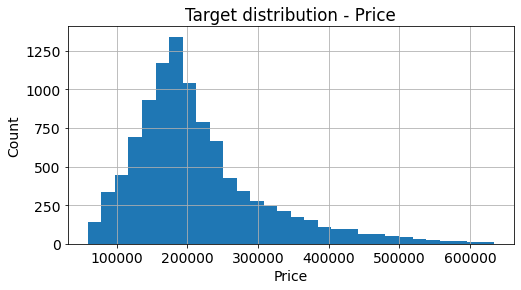

In [788]:
plt.figure(figsize=(8,4))
df_train['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Target distribution - Price')
plt.show()

Количественные переменные

In [789]:
df_train['PriceSQM'].quantile(.993), df_train['PriceSQM'].quantile(.005)

(7654.475640189014, 1240.0197830019438)

In [790]:
# посмотрим на количество объектов, имеющих выборосы
df_train.loc[(df_train['PriceSQM'] > df_train['PriceSQM'].quantile(.993))]['Id'].count(),\
       df_train.loc[(df_train['PriceSQM'] < df_train['PriceSQM'].quantile(.005))]['Id'].count() # , df_train['PriceSQM']

(70, 50)

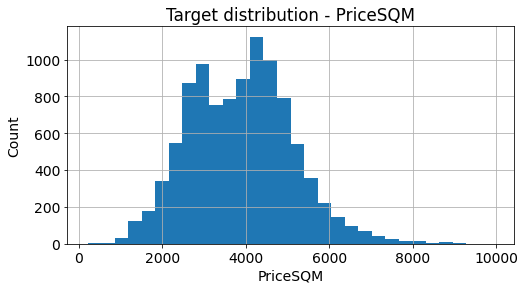

In [791]:
# проблема выбросов заключается в наличии квартир с очень маленькой площадю, которые дают очень большие цены
# отсечем маленькие площади и посмотрим на целевую переменную.
plt.figure(figsize=(8,4))
#df_train['PriceSQM'].hist(bins=30) 
df_train.loc[df_train['PriceSQM']<10000, 'PriceSQM'].hist(bins=30)
plt.xlabel('PriceSQM')
plt.ylabel('Count')
plt.title('Target distribution - PriceSQM')
plt.show()

In [792]:
# посмотрим на них попобробнее
df_train.sort_values(by='PriceSQM', ascending=False)[['DistrictId', 'Rooms', 'Square', 'HouseYear', 'PriceSQM']].head(10)
# 
#df_train.sort_values(by='Square', ascending=True).head(20)
#df_train.loc[(df_train['DistrictId'] == '28') & (df_train['HouseYear'] == 2015)]

,DistrictId,Rooms,Square,HouseYear,PriceSQM
4496,34,1.0,1.988943,1977,230463.537966
7470,1,1.0,1.136859,1977,159593.107918
161,45,1.0,2.954309,1977,148259.792432
4800,38,1.0,4.502784,1977,107329.937099
7033,88,2.0,5.497061,1977,75042.110444
1401,5,1.0,5.129222,1977,72032.840662
9869,27,0.0,2.377248,1977,53253.578837
8572,6,1.0,2.596351,2014,52996.529388
9067,1,3.0,4.823679,1977,49281.194174
328,27,3.0,4.390331,2016,36757.837204


In [793]:
# сформируем перечень признаков выраженных в числовом виде, для использования далее в матрице корреляции
df_num_features_list = df_train.select_dtypes(include=['float64', 'float32', 'float16', 'int64']).drop(['Price', 'PriceSQM'], axis=1).columns.to_list()

In [794]:
# выбросы PriceSQM порождаются некорректным значением  площади
# - менее 10 м - восстановим исходя из медианного значения площади комнаты в разрезе района и года постройки .
# для заполнения используем группы, где объектов в группе больше 10. если объектов в группе менее 10 заполняем медианной 
# площадью на комнату
# - и более 280 м.кв. (+стоимость за кв.м. менее 800) скорее всего это была неправильно указана площадь
# при восстановлении нужно будет учесть, что есть объекты, где количество комнат неправильно указано. 
# Пересчитаем их исходя из медианной площади комнаты по району, году постройки, там где объектов в гр.>5 и по 
# медианной площади на комнату где объектов < 5.
# объекты с восстановленной площадью пометим Square_restored
# объекты с восстановленным количестовм комнат пометим Rooms_restored
#med_RoomSquare_cond = (df_train[])
#med_RoomSquare = (df_train.loc[df_train['Square']>10, 'Square'] / df_train.loc[df_train['Square']>10, 'Rooms'])
# med_RoomSquare - средняя площадь комнаты по году постройки и району
def med_room_square(x):
    result = {
        'mean_room_square':x['Square'].sum() / x['Rooms'].sum(),
#        'median_room_square':(x['Square'] / x['Rooms'] if (x['Rooms'] > 0).all() else 0 ).median(),
        'median_room_square':(x['Square'] / x['Rooms']).median(),
       'obj_num':x['Id'].count(),
        'median_PriceSQM':x['PriceSQM'].median()
    }
    return pd.Series(result).round(2)
df_med_RoomSquare_by_DI_HY = df_train.loc[(df_train['Square'] > square_valid_min) & \
                                          (df_train['Square'] < square_valid_max) & \
                                          (df_train['Rooms'] > 0)]\
                             .groupby(['DistrictId', 'HouseYear'], as_index=False).apply(med_room_square)

df_med_RoomSquare_by_HY = df_train.loc[(df_train['Square'] > square_valid_min) & \
                                       (df_train['Square'] < square_valid_max) & \
                                       (df_train['Rooms'] > 0)]\
                          .groupby(['HouseYear'], as_index=False).apply(med_room_square)

df_med_RoomSquare_by_DI_HY.rename(columns={'mean_room_square':'mean_room_square_by_DI_HY',\
                                        'median_room_square':'median_room_square_by_DI_HY',\
                                        'obj_num':'obj_num_by_DI_HY',\
                                       'median_PriceSQM':'median_PriceSQM_by_DI_HY'}, inplace=True) 

df_med_RoomSquare_by_HY.rename(columns={'mean_room_square':'mean_room_square_by_HY',\
                                        'median_room_square':'median_room_square_by_HY',\
                                        'obj_num':'obj_num_by_HY',\
                                       'median_PriceSQM':'median_PriceSQM_by_HY'}, inplace=True) 

# вычислим медианное значение площади квартиры, приходящейся на одону комнату для вставки: где объектов в группировке менее 10, 
#  где не получилось вычислить и для расчетов количества комнат где площадь  приходящаяся на комнату слишком большая.
median_room_square = (df_train['Square'] / df_train['Rooms']).median()

In [795]:
# проверим есть ли нули или бесконечность (бесконечность если в ['Rooms'].sum() по группировке была нулевая)
df_med_RoomSquare_by_DI_HY.loc[(df_med_RoomSquare_by_DI_HY['median_room_square_by_DI_HY'] == np.inf) | df_med_RoomSquare_by_DI_HY['median_room_square_by_DI_HY'] == np.nan]


,DistrictId,HouseYear,mean_room_square_by_DI_HY,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY


In [796]:
#df_med_RoomSquare.sort_values(by='median_room_square', ascending=False).info()
df_med_RoomSquare_by_DI_HY.loc[(df_med_RoomSquare_by_DI_HY['DistrictId'].isin([27])) & (df_med_RoomSquare_by_DI_HY['HouseYear'].isin([2016]))]

,DistrictId,HouseYear,mean_room_square_by_DI_HY,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY
723,27,2016,33.94,34.42,78.0,2789.11


In [797]:
#df_med_RoomSquare_by_HY.to_excel('..\L10\df_med_RoomSquare_by_HY.xls', index=False)

In [798]:
##  проверка работы функции
'''
def mean_room_sqare(x):
    result = {
        'mean_room_square_1':(x['Square'] / x['Rooms']).mean(),
        'mean_room_square_2':x['Square'].sum() / x['Rooms'].sum(),
        'median_room_square':(x['Square'] / x['Rooms']).median(),
        'count':x['Id'].count(),
        'median_PriceSQM':x['PriceSQM'].median()
    }
    return pd.Series(result).round(2)
med_RoomSquare_test = df_train.loc[df_train['Square']>10].groupby(['DistrictId', 'HouseYear'], as_index=False).apply(mean_room_sqare)
#med_RoomSquare_test.loc[med_RoomSquare_test['count'] > 3]
'''

"\ndef mean_room_sqare(x):\n    result = {\n        'mean_room_square_1':(x['Square'] / x['Rooms']).mean(),\n        'mean_room_square_2':x['Square'].sum() / x['Rooms'].sum(),\n        'median_room_square':(x['Square'] / x['Rooms']).median(),\n        'count':x['Id'].count(),\n        'median_PriceSQM':x['PriceSQM'].median()\n    }\n    return pd.Series(result).round(2)\nmed_RoomSquare_test = df_train.loc[df_train['Square']>10].groupby(['DistrictId', 'HouseYear'], as_index=False).apply(mean_room_sqare)\n#med_RoomSquare_test.loc[med_RoomSquare_test['count'] > 3]\n"

In [799]:
# группируем по району и году постройкуи, есть ли группы где количество объектов в группе больше 10 таких 88 группировок.
# всего группировок 3154 
df_med_RoomSquare_by_DI_HY.loc[df_med_RoomSquare_by_DI_HY['obj_num_by_DI_HY'] >= 5 ].sort_values(by='median_room_square_by_DI_HY', ascending=False)
# 1736 группировок, где 1 объект в группировке. За счет этого получаются большие средние площади комнаты и очень маленькие
# 

,DistrictId,HouseYear,mean_room_square_by_DI_HY,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY
1552,63,2018,52.22,50.97,5.0,5586.74
1551,63,2017,42.80,48.98,5.0,5789.52
960,38,1977,51.15,48.61,8.0,4649.88
718,27,2011,36.91,46.73,6.0,2929.55
1718,74,2017,44.51,46.57,12.0,3307.90
...,...,...,...,...,...,...
2151,99,1973,21.55,20.85,10.0,4034.81
1136,46,1971,21.12,20.72,12.0,4630.86
777,29,1969,21.53,20.28,6.0,4804.73
2201,101,1970,20.09,19.98,5.0,4267.14


In [800]:
df_train.loc[df_train['Rooms'] == 0]
#df_train.loc[df_train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PriceSQM
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.110646,4108.784399
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976788,2348.119347
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.338463,4385.488771
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.918007,2498.580012
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.260887,1419.282909
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.799112,2612.112170
9767,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,B,11,3097,0,NaN,0,0,B,268394.744389,1938.880408
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.941798,53253.578837


In [801]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,PriceSQM
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,3988.383777
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,3755.437224
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,208.293451
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,2918.525328
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,3910.052336
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,4692.375993
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,230463.537966


Категориальные переменные
Категориальные признаки нужно перевести в численное предоставление, которое бы могло быть отранжировано по принципу от лучшего к худшему или наоборот.
1. Перевести категорию в какой то индекс .
2. Сделать бинарные признаки (dummy признаки, one-hot-encoding).
2.1. Двоичное кодирование.
3. Feature encoding кодирование категориального признакаа через другой признак (возможный вариант для данного датасета).
4. Выразить признак через самого себя (например value_counts())

Рашка стр 112.
https://www.kaggle.com/waydeherman/tutorial-categorical-encoding


In [802]:
df_train.select_dtypes('object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [803]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [804]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [805]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [806]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# Обработка выбросов
Редко встречающиеся признаки объектов
1. Исключить данные из модели из обучающего набора данных (на тесте и на реальных данных не исключаем).
2. Заменять выбросы разными методами (медианы, средние значения, обрубание, построение моделей и т.п.)
3. Включение доп признаков, показывающих, что есть выброс.
4. Ничего не делать.

In [807]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  int32  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [808]:
l = ['mean_room_square_by_DI_HY', 'median_room_square_by_DI_HY', 'obj_num_by_DI_HY', 'median_PriceSQM_by_DI_HY',\
    'mean_room_square_by_HY', 'median_room_square_by_HY', 'obj_num_by_HY', 'median_PriceSQM_by_HY',\
     'Square_restored']
for i in l:
    if i in df_train.columns:
        df_train.drop(i, axis=1, inplace=True)

df_train = df_train.merge(df_med_RoomSquare_by_DI_HY, on=['DistrictId', 'HouseYear'], how='left')
df_train = df_train.merge(df_med_RoomSquare_by_HY, on=['HouseYear'], how='left')

# подстрахуемся и заполним созможные na inf
df_train.loc[df_train['median_room_square_by_HY'].isna() ,'obj_num_by_HY'] = 0
df_train.loc[df_train['median_room_square_by_DI_HY'].isna(), 'obj_num_by_DI_HY'] = 0
df_train.loc[df_train['median_room_square_by_HY'].isna(), 'median_room_square_by_HY'] = median_room_square

df_train.loc[df_train['median_room_square_by_DI_HY'].isna(), 'median_PriceSQM_by_DI_HY'] = \
 df_train.loc[df_train['median_room_square_by_DI_HY'].isna(), 'median_PriceSQM_by_HY']

df_train.loc[df_train['median_room_square_by_DI_HY'].isna(), 'median_room_square_by_DI_HY'] = \
 df_train.loc[df_train['median_room_square_by_DI_HY'].isna(), 'median_room_square_by_HY']


df_train['Square_restored'] = 0




In [809]:
df_train.loc[df_train['Square'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,PriceSQM,mean_room_square_by_DI_HY,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored


In [810]:
df_train['Square_r'] = 0 # создадим колонку, куда будем записывать восстанавливаемую площадь.

#cond_0 = (df_train['Square'] < df_train['LifeSquare'])
#df_train['Square_r'], df_train['LifeSquare'] =\
#           np.where(cond_0, (df_train['LifeSquare'], df_train['Square']), (df_train['Square'], df_train['LifeSquare']))        
#df_train.loc[cond_0, 'Square_restored'] = 1

# Т.к. модель работает ценой м.кв. нужно постараться хорошо обработать выбросы по полощади.
# Выбросами считаем S < 16 B S > 280.
# S < 20 S<LS - кривая and S  PriceSQM > 8000 Room > 0 - восстанавливаем по Room * (df_med_RoomSquare_by_DI_HY or df_med_RoomSquare_by_HY


# если площадь маленькая и содержит ошибку неадекватная, восстановим площадь через среднюю площадь комнаты и число комнтат

cond_1= (df_train['Square'] < square_valid_min)\
               & (df_train['Square'] < df_train['LifeSquare']) \
               & (df_train['Rooms'] > 0)

# сначала заполним S для объектов с кривой площадью
df_train.loc[cond_1 & (df_train['obj_num_by_DI_HY'] >= min_obj_num_in_group), 'Square_r'] = \
   df_train.loc[cond_1 & (df_train['obj_num_by_DI_HY'] >= min_obj_num_in_group), 'Rooms'] * \
   df_train.loc[cond_1 & (df_train['obj_num_by_DI_HY'] >= min_obj_num_in_group), 'median_room_square_by_DI_HY']

# если не нашлсь комбинации района и города посчитаем среднюю площадь по году постройки
df_train.loc[(cond_1) & (df_train['obj_num_by_DI_HY'] < min_obj_num_in_group), 'Square_r'] = \
   df_train.loc[(cond_1) & (df_train['obj_num_by_DI_HY'] < min_obj_num_in_group), 'Rooms'] * \
   df_train.loc[(cond_1) & (df_train['obj_num_by_DI_HY'] < min_obj_num_in_group), 'median_room_square_by_HY']

# если вдруг еще остались объекты 
df_train.loc[(cond_1) & (df_train['Square_r'] == 0), 'Square_r'] = \
   df_train.loc[(cond_1) & (df_train['Square_r'] == 0), 'Rooms'] * median_room_square

df_train.loc[cond_1, 'Square_restored'] = 1
    
# если площадь маленькая и возможно правильная умножим на 10, возможно это опечатка  -- перенести
cond_2 = (df_train['Square'] < square_valid_min)\
               & (df_train['Square'] >= df_train['LifeSquare']) \

df_train.loc[(cond_2) & (df_train['Square_r'] == 0), 'Square_r'] = \
               df_train.loc[(cond_2) & (df_train['Square_r'] == 0), 'Square'] *10

df_train.loc[cond_2, 'Square_restored'] = 1

# если площадь слишком большая разделим на 10 возможно это опечатка.
cond_3 =(df_train['Square'] > square_valid_max)

df_train.loc[(cond_3) & (df_train['Square_r'] == 0), 'Square_r'] = \
               df_train.loc[(cond_3) & (df_train['Square_r'] == 0), 'Square'] / 10

df_train.loc[cond_3, 'Square_restored'] = 1

In [811]:
df_train.loc[df_train['Square'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,mean_room_square_by_DI_HY,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r


In [812]:
# пересчитаем PriceSQM и перенесем Square_r в Square
df_train.loc[df_train['Square_restored'] == 1, 'PriceSQM'] = \
          df_train.loc[df_train['Square_restored'] == 1,'Price'] / df_train.loc[df_train['Square_restored'] == 1, 'Square_r']

df_train.loc[df_train['Square_restored'] == 1, 'Square'] = df_train.loc[df_train['Square_restored'] == 1, 'Square_r']

In [813]:
# можно выборосы по целевому показателю пересчитать по средней стоимости кв.м. для района, года постройки.
df_train.sort_values(by='PriceSQM', ascending=False)[['DistrictId', 'Rooms', 'Square', 'Square_r', 'HouseYear', 'Price',  'PriceSQM', 'Square_restored']].head()

,DistrictId,Rooms,Square,Square_r,HouseYear,Price,PriceSQM,Square_restored
4496,34,1.0,28.680000,28.68,1977,458378.777006,15982.523606,1
161,45,1.0,32.020000,32.02,1977,438005.182323,13679.112502,1
2783,202,2.0,42.353485,0.00,1933,502085.860162,11854.652892,0
753,94,1.0,33.521641,0.00,2015,381912.162109,11393.003236,0
9961,181,1.0,34.911269,0.00,1955,397528.736061,11386.831424,0


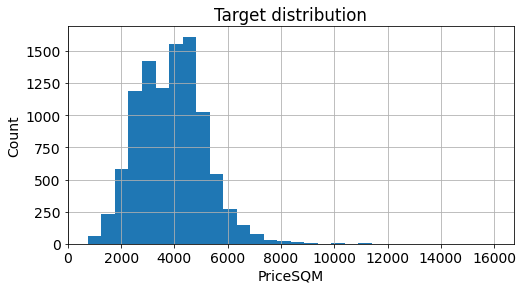

In [814]:
# посмотрим еще раз на график распределения целевой переменной
plt.figure(figsize=(8,4))
#df_train['PriceSQM'].hist(bins=30)
df_train['PriceSQM'].hist(bins=30)
plt.xlabel('PriceSQM')
plt.ylabel('Count')
plt.title('Target distribution')
plt.show()

In [815]:
df_train_res = df_train.copy()

In [816]:
df_train_res = df_train.copy()

In [817]:
df_train['Rooms'].value_counts()
#df_train['Rooms'].unique()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [818]:
# восстанавливаем количество комнат где 0 и больше 5 через среднюю площадь комнаты по району, году постройки. В несколько этапов.
df_train['Rooms_outlier'] = 0
cond_4 = (df_train['Rooms'] < rooms_valid_min) | (df_train['Rooms'] > rooms_valid_max)
df_train.loc[cond_4, 'Rooms'] = (df_train.loc[cond_4, 'Square'] / df_train.loc[cond_4, 'median_room_square_by_DI_HY']).round(0)
df_train.loc[cond_4, 'Rooms_outlier'] = 1

In [819]:
# уточним площади однокомнатных квартир, где площади, приходящиеся на комнату больше 50 кв.м
cond_5 = (df_train['Rooms'] == rooms_valid_min) & (df_train['Square'] > one_room_square_valid_max)
df_train.loc[cond_5, 'Rooms'] = (df_train.loc[cond_5, 'Square'] / \
                                 np.where(df_train.loc[cond_5, 'obj_num_by_DI_HY'] >= min_obj_num_in_group, \
                                          df_train.loc[cond_5, 'median_room_square_by_DI_HY'],
                                         df_train.loc[cond_5, 'median_room_square_by_HY'])).round(0)
df_train.loc[cond_5, 'Rooms_outlier'] = 1
# проверим остались ли однокомнатные квартиры с гигантской площадью.
df_train.loc[(df_train['Rooms'] == 1) & (df_train['Square'] > square_valid_max )]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier


In [820]:
df_train['Rooms'].value_counts()

2.0    4056
1.0    3513
3.0    2253
4.0     155
5.0      21
6.0       2
Name: Rooms, dtype: int64

In [821]:
##  эта задача больше полезна для качественной обработки выбросов на реальных данных  т.к. здесь выборосов по комнатам не много.
## можно заменить средней площадью: комнаты жилая площадь/количество комнат.
## к студиям можно отнести: количество комнат 0 площадь кухни 0. Если площадь кухни не 0, то считать выбросом и 
## через среднюю площадь
df_train[df_train['Rooms'].isin([0,6,10,19])]
#df_train['Rooms'].isin(0,10,19)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier
5283,11055,151,6.0,174.649522,174.837082,15.0,10,12.0,1958,0.236108,...,174.65,1.0,1332.76,28.85,28.30,51.0,4542.96,0,0.0,1
7644,7917,27,6.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,35.06,5.0,3243.43,31.93,33.19,94.0,4386.97,0,0.0,1


In [822]:
# выбросов по площади кухни много можно улучшить модель,если попытаться прарвильно определить площадь кухни.
# можно вычислить площадь кухни, как площать общая - жилая или как
# площадь кухни на ед.площади квартиры. Вряд ли госты помогут, потому, что дома в разные года построены и были разные стандарты
# есть вариант, привязаться с расчетом средней площади кухни к району и году постройки
df_train['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [823]:
# визуализируем объекты с неадекватной площадью кухни
#df_train[(df_train['KitchenSquare'] <=3) | (df_train['KitchenSquare']>10)]
df_train[(df_train['KitchenSquare'] == 13)].describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier
count,67.000000,67.000000,67.000000,65.000000,67.0,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.00000,67.000000,67.0,67.0,67.000000
mean,60.850746,2.089552,69.222082,39.391409,13.0,8.746269,16.373134,2003.104478,0.102457,20.238806,...,36.548806,43.582090,3685.469552,32.757015,33.798806,444.00000,3584.643134,0.0,0.0,0.164179
std,53.020937,0.792605,20.406698,16.598287,0.0,5.668476,7.963621,17.440057,0.102624,16.412384,...,7.302814,102.972804,1407.975581,2.820387,3.704826,819.71427,729.077619,0.0,0.0,0.373234
min,0.000000,1.000000,32.712359,11.047605,13.0,1.000000,0.000000,1955.000000,0.000000,1.000000,...,23.410000,1.000000,1178.420000,23.670000,23.110000,15.00000,2801.200000,0.0,0.0,0.000000
25%,26.000000,2.000000,53.064068,24.200116,13.0,4.000000,12.000000,2003.500000,0.025172,5.000000,...,32.760000,2.000000,2735.240000,32.070000,32.790000,78.00000,2893.770000,0.0,0.0,0.000000
50%,34.000000,2.000000,65.525284,40.548087,13.0,7.000000,17.000000,2012.000000,0.072158,17.000000,...,34.420000,4.000000,3307.900000,33.530000,34.390000,99.00000,3454.450000,0.0,0.0,0.000000
75%,81.500000,3.000000,78.837999,46.622878,13.0,12.500000,24.500000,2015.000000,0.127376,34.000000,...,39.950000,24.000000,4653.870000,34.060000,35.670000,298.00000,4356.240000,0.0,0.0,0.000000
max,200.000000,4.000000,132.871746,91.642249,13.0,24.000000,30.000000,2020.000000,0.437885,53.000000,...,55.560000,416.000000,7891.600000,35.870000,39.310000,2639.00000,5072.530000,0.0,0.0,1.000000


In [824]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [825]:
conditition_ks = (df_train['KitchenSquare'].isna()) \
                 | (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975))
df_train.loc[conditition_ks, 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [826]:
df_train['KitchenSquare'].value_counts().sort_index()

3.0     3183
4.0       39
5.0     1169
6.0     1227
7.0      609
8.0     1306
9.0      843
10.0    1075
11.0     233
12.0     249
13.0      67
Name: KitchenSquare, dtype: int64

In [827]:
df_train['Floor'].value_counts().sort_index()

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

In [828]:
# что за нулевые этажи
# выбросов по количеству немного. здесь борьба с выбросами больше нацелена на получение результата
# при поступлении неадекватных данных нежели, чем скажется на точности модели.
##df_train.loc[conditition_ks, 'KitchenSquare']
# интернет говорит, что самые высокие жилые дома в Мск это 34 этажа.
# аппартаменты Мск сити 75 этажей.
df_train['HouseFloor'].value_counts().sort_index()

0.0       269
1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0       27
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

In [829]:
# визуализируем неадекватные по этажности объекты
# в основном это объекты 1977 года постройки. Можно посмотреть объекты по годам постройки, район и определить средний этаж по году постройки.
#df_train[(df_train['HouseFloor'] == 0)].describe()
df_train[(df_train['HouseFloor'] == 0) & (df_train['HouseYear'] > 1977)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier
303,13113,27,1.0,37.805231,2.228592,11.0,6,0.0,2015,0.017647,...,35.40,60.0,2813.73,34.04,34.39,298.0,2876.81,0,0.0,0
909,5575,27,1.0,41.941912,4.437475,3.0,10,0.0,2016,0.211401,...,34.42,78.0,2789.11,34.08,34.43,302.0,2893.77,0,0.0,0
1829,4378,27,3.0,106.958871,0.641822,3.0,17,0.0,2018,0.072158,...,37.74,29.0,2911.22,33.24,33.40,175.0,3124.87,0,0.0,0
3565,12446,45,2.0,66.204483,60.538230,3.0,16,0.0,2015,0.195781,...,32.16,6.0,5585.55,34.04,34.39,298.0,2876.81,0,0.0,0
4303,4000,74,2.0,73.059245,3.769436,3.0,10,0.0,2016,0.075779,...,43.23,5.0,3304.97,34.08,34.43,302.0,2893.77,0,0.0,0
4685,10521,38,3.0,104.211396,106.340403,3.0,20,0.0,2017,0.060753,...,33.95,2.0,4225.90,33.71,34.33,308.0,3050.41,0,0.0,0
5178,14564,34,4.0,97.524848,97.046136,3.0,20,0.0,2016,0.069753,...,29.59,10.0,3906.13,34.08,34.43,302.0,2893.77,0,0.0,0
5492,2517,45,2.0,63.326746,66.799547,3.0,4,0.0,2018,0.195781,...,30.41,6.0,5823.11,33.24,33.40,175.0,3124.87,0,0.0,0
5736,13231,27,1.0,44.163968,46.614944,3.0,19,0.0,2016,0.017647,...,34.42,78.0,2789.11,34.08,34.43,302.0,2893.77,0,0.0,0
5861,12828,27,1.0,40.288833,1.487210,3.0,11,0.0,2016,0.211401,...,34.42,78.0,2789.11,34.08,34.43,302.0,2893.77,0,0.0,0


In [830]:
df_train[(df_train['HouseFloor'] == 0) & (df_train['HouseYear'] <= 1977)].describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier
count,253.000000,253.000000,253.000000,39.000000,253.00000,253.000000,253.0,253.0,253.000000,253.000000,...,253.000000,253.000000,253.000000,2.530000e+02,2.530000e+02,253.0,2.530000e+02,253.000000,253.000000,253.000000
mean,38.422925,1.857708,63.450075,43.038649,3.29249,8.909091,0.0,1977.0,0.084185,9.359684,...,35.196047,258.150198,3151.260316,3.326000e+01,3.358000e+01,2639.0,2.901240e+03,0.003953,0.093962,0.094862
std,28.143464,0.794019,22.764874,24.859681,1.47244,5.425143,0.0,0.0,0.083756,13.493424,...,3.445052,176.395775,908.580584,7.119511e-15,7.119511e-15,0.0,9.112975e-13,0.062869,1.494563,0.293605
min,1.000000,1.000000,23.772476,0.873147,3.00000,1.000000,0.0,1977.0,0.000000,0.000000,...,26.630000,1.000000,1348.720000,3.326000e+01,3.358000e+01,2639.0,2.901240e+03,0.000000,0.000000,0.000000
25%,27.000000,1.000000,45.592499,32.565823,3.00000,5.000000,0.0,1977.0,0.017647,2.000000,...,33.280000,57.000000,2615.890000,3.326000e+01,3.358000e+01,2639.0,2.901240e+03,0.000000,0.000000,0.000000
50%,27.000000,2.000000,59.963701,40.808976,3.00000,8.000000,0.0,1977.0,0.072158,2.000000,...,33.910000,322.000000,2681.370000,3.326000e+01,3.358000e+01,2639.0,2.901240e+03,0.000000,0.000000,0.000000
75%,62.000000,2.000000,78.363309,50.772795,3.00000,12.000000,0.0,1977.0,0.075779,9.000000,...,38.300000,416.000000,3251.270000,3.326000e+01,3.358000e+01,2639.0,2.901240e+03,0.000000,0.000000,0.000000
max,169.000000,5.000000,170.016872,138.910187,13.00000,26.000000,0.0,1977.0,0.437885,53.000000,...,48.610000,471.000000,6357.700000,3.326000e+01,3.358000e+01,2639.0,2.901240e+03,1.000000,23.772476,1.000000


In [831]:
# посмотрим на объекты где этажность больше этажа, но эатжность не ноль
conditition1 = (df_train['HouseFloor'] - df_train['Floor'] == -1) & (df_train['HouseFloor']> 0) & (df_train['Floor']> 0)
#conditition1 = (df_train['HouseFloor'] - df_train['Floor'] == -1)
df_train[conditition1].describe()
# объектов, где этажность меньше на 1 количества этажей третья часть от всех отклонений 693 из 1825. Возможно люди перепутали 
# или так обозначают переоборудованные под жилые чердаки и технические этажи?
# если бы были адреса, то можно было бы восстановить этажность по адресу.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,median_room_square_by_DI_HY,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier
count,693.000000,693.000000,693.000000,594.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,...,693.000000,693.000000,693.000000,693.00000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,57.451659,1.981241,56.324927,38.509497,5.988456,10.663781,9.663781,1980.988456,0.121563,24.932179,...,30.284632,55.070707,4008.199120,28.76974,28.826681,627.877345,3902.656089,0.001443,0.092506,0.034632
std,45.586855,0.815986,20.289171,32.559909,2.455943,5.538444,5.538444,20.234032,0.125909,15.677282,...,6.479352,125.494246,1172.846463,4.09136,4.590890,983.182210,767.055065,0.037987,2.435205,0.182978
min,0.000000,1.000000,25.543282,1.477182,3.000000,2.000000,1.000000,1917.000000,0.000000,0.000000,...,14.260000,0.000000,1348.720000,21.56000,22.010000,3.000000,2801.200000,0.000000,0.000000,0.000000
25%,23.000000,1.000000,41.478548,22.967329,3.000000,6.000000,5.000000,1967.000000,0.017647,11.000000,...,25.020000,2.000000,3052.220000,24.55000,23.950000,110.000000,2901.240000,0.000000,0.000000,0.000000
50%,46.000000,2.000000,51.329603,32.801518,6.000000,10.000000,9.000000,1977.000000,0.072158,25.000000,...,30.310000,5.000000,4140.790000,28.72000,28.300000,158.000000,4348.640000,0.000000,0.000000,0.000000
75%,88.000000,3.000000,66.151460,45.829259,8.000000,15.000000,14.000000,1994.000000,0.211401,35.000000,...,33.910000,16.000000,4686.670000,33.26000,33.580000,302.000000,4409.380000,0.000000,0.000000,0.000000
max,208.000000,5.000000,170.379494,638.163193,13.000000,26.000000,25.000000,2019.000000,0.521867,74.000000,...,71.330000,471.000000,8687.400000,35.87000,39.310000,2639.000000,7293.340000,1.000000,64.106519,1.000000


In [832]:
## Даже если по общим оценкам у нас этажность соответствует количеству этажей то в отдельных объектах такое несоответствие
## быть. Если мы этажность  приведем к средней, то после этого останутся объекты, где этаж больше этажности, а это не правильно
## Важно выдержать последовательность приведения этажей и этажности.
## - правим этажность.
## - потом правим этаж.

In [833]:
df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df_train.loc[df_train['HouseFloor'] < df_train['Floor'], 'HouseFloor_outlier'] = 1

In [834]:
# заполняем медианой только те, где количество этажей равно 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train["HouseFloor"].median()

In [835]:
floor_more_hfloor_i = df_train.loc[df_train['HouseFloor'] < df_train['Floor']].index
floor_more_hfloor_i

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [836]:
# это точно нужно поправить потому, что мы совсем не избавились от некорректных данных (1556 строк, где этажность больше этажа)
# возможно если мы доверяем этажу:
# можно определить этажность по этажу или перевести этажность в категорию или ввести признак первого и последнего этажа.
df_train[df_train['HouseFloor'] < df_train['Floor']].describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier,HouseFloor_outlier
count,1610.000000,1610.000000,1610.000000,1166.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,...,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.0
mean,49.001242,1.937888,58.241493,38.556064,5.195031,11.226708,7.447205,1984.011180,0.114228,22.722981,...,85.523602,3789.395932,30.259720,30.470708,1025.081366,3590.895267,0.004348,0.202367,0.050932,1.0
std,41.130921,0.814638,21.024297,28.973296,2.595924,5.821258,6.226410,19.702697,0.113476,16.833969,...,146.258486,1140.718898,4.010002,4.492433,1179.340858,778.685761,0.065815,3.231861,0.219927,0.0
min,0.000000,1.000000,17.498542,0.370619,3.000000,2.000000,1.000000,1914.000000,0.000000,0.000000,...,0.000000,1198.840000,21.560000,22.010000,1.000000,2801.200000,0.000000,0.000000,0.000000,1.0
25%,23.000000,1.000000,42.805899,22.721132,3.000000,6.000000,1.000000,1973.000000,0.019509,5.000000,...,2.000000,2814.665000,25.610000,25.540000,140.000000,2901.240000,0.000000,0.000000,0.000000,1.0
50%,34.000000,2.000000,54.453049,33.027907,5.000000,10.000000,5.000000,1977.000000,0.072158,23.000000,...,8.000000,3851.385000,33.260000,33.580000,209.000000,3050.410000,0.000000,0.000000,0.000000,1.0
75%,70.750000,3.000000,68.037187,47.334108,7.000000,16.000000,12.000000,2002.000000,0.194489,34.000000,...,82.000000,4547.150000,33.260000,33.580000,2639.000000,4367.260000,0.000000,0.000000,0.000000,1.0
max,209.000000,5.000000,190.857689,638.163193,13.000000,28.000000,25.000000,2020.000000,0.521867,74.000000,...,471.000000,8687.400000,35.870000,39.310000,2639.000000,7540.730000,1.000000,72.780000,1.000000,1.0


In [837]:
df_train.loc[floor_more_hfloor_i, 'Floor'] = \
df_train.loc[floor_more_hfloor_i, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [838]:
df_train[df_train['HouseFloor'] < df_train['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,obj_num_by_DI_HY,median_PriceSQM_by_DI_HY,mean_room_square_by_HY,median_room_square_by_HY,obj_num_by_HY,median_PriceSQM_by_HY,Square_restored,Square_r,Rooms_outlier,HouseFloor_outlier


In [839]:
df_train['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [840]:
# Странно, что такая конструкция работает. 
df_train['HouseYear_outlier'] = 0
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = 2020
# Правильная запис
# df_train[df_train['HouseYear'] > 2020]['HouseYear'] = 2020

In [841]:
df_train['LifeSquare_nan'] = df_train['LifeSquare'].isna() * 1

In [842]:
df_train['LifeSquare_restored'] = 0
df_train['LifeSquare_part'] = (df_train['LifeSquare'] / df_train['Square']).round(2)
df_train['LifeSquare_part'].fillna(0, inplace=True )
df_train['LifeSquare_part'].isna().sum()

0

In [843]:
# попробуем восстановить недаекватную жилую площадь для 1к квартир доля LS 0.55+-0.15
cond_lsn_1 = (df_train['Rooms'] == 1) & (~df_train['LifeSquare_part'].between(0.4, 0.7))
df_train.loc[cond_lsn_1, 'LifeSquare'] = \
     df_train.loc[cond_lsn_1, 'Square'] * np.clip(np.random.normal(0.55, 0.08), a_min=0.3, a_max=0.85)
#df_train.loc[cond_lsn_1, 'Square'] * np.clip(np.random.normal(0.55, 0.08), a_min=0.3, a_max=0.85)
#cond_lsn_1.value_counts() np.clip(y_train_sqm, a_min=800, a_max=8000)
# pd.DataFrame(np.clip(np.random.normal(0.55, 0.05, size=1000), a_min=0.3, a_max=0.85)).round(2).hist(bins=20)

In [844]:
cond_lsn_2 = (df_train['Rooms'] == 2) & (~df_train['LifeSquare_part'].between(0.45, 0.75))
df_train.loc[cond_lsn_2, 'LifeSquare'] = \
    df_train.loc[cond_lsn_2, 'Square'] * np.clip(np.random.normal(0.6, 0.04), a_min=0.3, a_max=0.8)
cond_lsn_2.value_counts()
#(df_train.loc[cond_lsn_2, 'Square']).hist(bins=50)

False    8463
True     1537
dtype: int64

In [845]:
cond_lsn_3 = (df_train['Rooms'] == 3) & (~df_train['LifeSquare_part'].between(0.47, 0.77))
df_train.loc[cond_lsn_3, 'LifeSquare'] = \
    df_train.loc[cond_lsn_3, 'Square'] * np.clip(np.random.normal(0.62, 0.08), a_min=0.32, a_max=0.85)
cond_lsn_3.value_counts()

False    9278
True      722
dtype: int64

In [846]:
cond_lsn_4 = (df_train['Rooms'] == 4) & (~df_train['LifeSquare_part'].between(0.5, 0.8))
df_train.loc[cond_lsn_4, 'LifeSquare'] = \
    df_train.loc[cond_lsn_4, 'Square'] * np.clip(np.random.normal(0.65, 0.04), a_min=0.35, a_max=0.9)
cond_lsn_4.value_counts()

False    9962
True       38
dtype: int64

In [847]:
cond_lsn_5 = (df_train['Rooms'] >=5) & (~df_train['LifeSquare_part'].between(0.5, 0.8))
df_train.loc[cond_lsn_5, 'LifeSquare'] = \
    df_train.loc[cond_lsn_5, 'Square'] * np.clip(np.random.normal(0.65, 0.08), a_min=0.35, a_max=0.9)
cond_lsn_5.value_counts()

False    9991
True        9
dtype: int64

In [848]:
df_train.loc[cond_lsn_1 | cond_lsn_2 | cond_lsn_3 | cond_lsn_4 | cond_lsn_5, 'LifeSquare_restored'] = 1

In [849]:
df_train.loc[df_train['LifeSquare_restored'] == 1, 'LifeSquare_part'] = \
                        (df_train.loc[df_train['LifeSquare_restored'] == 1, 'LifeSquare'] \
                        / df_train.loc[df_train['LifeSquare_restored'] == 1, 'Square']).round(2)

In [850]:
df_train.sort_values(by='Square', ascending=False)[['DistrictId', 'Rooms', 'Square', 'Square_r', 'LifeSquare', 'HouseYear', 'Price',  'PriceSQM', 'Square_restored', 'LifeSquare_restored']].head()

,DistrictId,Rooms,Square,Square_r,LifeSquare,HouseYear,Price,PriceSQM,Square_restored,LifeSquare_restored
1906,86,5.0,275.645284,0.0,217.964981,2011,455264.882666,1651.633128,0,1
7644,27,6.0,212.932361,0.0,168.375084,2008,302211.260887,1419.282909,0,1
1776,27,4.0,200.334539,0.0,141.529622,2013,528560.506016,2638.389304,0,1
9307,23,5.0,198.930182,0.0,123.139863,2011,345665.209100,1737.620735,0,0
1606,56,3.0,190.857689,0.0,107.376164,2007,338644.075979,1774.327659,0,0


In [851]:
df_train['Rooms'].value_counts()

2.0    4056
1.0    3513
3.0    2253
4.0     155
5.0      21
6.0       2
Name: Rooms, dtype: int64

In [852]:
df_train['LifeSquare'].describe()
#df_train.loc[df_train['Rooms'] == 2, 'LifeSquare_part'].hist(figsize=(5, 5), bins=20, grid=True)

count    10000.000000
mean        33.845325
std         12.161227
min          8.822988
25%         24.465552
50%         32.076601
75%         40.827700
max        217.964981
Name: LifeSquare, dtype: float64

## Обработка пропусков

In [853]:
#from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.preprocessing import RobustScaler

In [854]:
col_for_HC1 = ['Social_1', 'Social_2', 'Social_3', 
       'Helthcare_2','Healthcare_1']
target_HC1 = 'Healthcare_1'
df_train_HC1 = df_train[col_for_HC1].copy()
df_train_HC1[target_HC1] = df_train_HC1[target_HC1].fillna(9999).astype('int')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           10000 non-null  object 
 1   DistrictId                   10000 non-null  int32  
 2   Rooms                        10000 non-null  float64
 3   Square                       10000 non-null  float64
 4   LifeSquare                   10000 non-null  float64
 5   KitchenSquare                10000 non-null  float64
 6   Floor                        10000 non-null  int64  
 7   HouseFloor                   10000 non-null  float64
 8   HouseYear                    10000 non-null  int64  
 9   Ecology_1                    10000 non-null  float64
 10  Ecology_2                    10000 non-null  object 
 11  Ecology_3                    10000 non-null  object 
 12  Social_1                     10000 non-null  int64  
 13  Social_2         

In [855]:
y_train_HC1 = df_train_HC1.loc[(df_train_HC1[target_HC1] != 9999), target_HC1]
X_train_HC1 = df_train_HC1.loc[(df_train_HC1[target_HC1] != 9999)].drop(target_HC1, axis=1)

In [856]:
X_test_HC1 = df_train_HC1.loc[(df_train_HC1[target_HC1] == 9999)].drop(target_HC1, axis=1)

In [857]:
print(X_train_HC1.info())
print(X_test_HC1.info())
print(len(y_train_HC1))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 1 to 9998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Social_1     5202 non-null   int64
 1   Social_2     5202 non-null   int64
 2   Social_3     5202 non-null   int64
 3   Helthcare_2  5202 non-null   int64
dtypes: int64(4)
memory usage: 203.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4798 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Social_1     4798 non-null   int64
 1   Social_2     4798 non-null   int64
 2   Social_3     4798 non-null   int64
 3   Helthcare_2  4798 non-null   int64
dtypes: int64(4)
memory usage: 187.4 KB
None
5202


In [858]:
scaler_HC1 = RobustScaler()

In [859]:
col_for_scale_HC1 = ['Social_1', 'Social_2', 'Social_3', 'Helthcare_2']
X_train_HC1[col_for_scale_HC1] = scaler_HC1.fit_transform(X_train_HC1[col_for_scale_HC1])

In [860]:
X_test_HC1[col_for_scale_HC1] = scaler_HC1.transform(X_test_HC1[col_for_scale_HC1])

In [861]:
y_train_HC1 = y_train_HC1.values

In [862]:
# применим метод KNN для восстановления HC_1
# опытным путем было установлено, что наилучше результаты даеет параметр n_neighbors=2.
clf_HC1 = KNeighborsClassifier(n_neighbors=2)
clf_HC1.fit(X_train_HC1, y_train_HC1)
y_pred_HC1 = clf_HC1.predict(X_test_HC1)

In [863]:
#df_test_HC1_ = df_train.loc[df_train[target_HC1].isna()][col_for_scale_HC1].copy()

#df_test_HC1_[col_for_scale_HC1] = scaler_HC1.transform(df_test_HC1_[col_for_scale_HC1])
#df_test_HC1_ = scaler_HC1.transform(df_test_HC1_)
           
#y_pred_HC1_ = clf_HC1.predict(df_test_HC1_)      
#df_test_HC1_
#y_pred_HC1_
# array([  32,    0,  990, ...,    0, 1020,  125])

In [864]:
df_HC1_pred = X_test_HC1
df_HC1_pred['Healthcare_1_pred'] = y_pred_HC1
df_HC1_pred.drop(['Social_1', 'Social_2', 'Social_3','Helthcare_2'], axis=1, inplace=True)

In [865]:
df_train = df_train.merge(df_HC1_pred, left_index=True, right_index=True, how='left')

In [866]:
cond_HC1_1 = df_train['Healthcare_1'].isna()
df_train.loc[cond_HC1_1, 'Healthcare_1'] = df_train.loc[cond_HC1_1, 'Healthcare_1_pred']
df_train['Healthcare_1_pred'] = 0
df_train.loc[~cond_HC1_1,'Healthcare_1_pred'] = 1

In [867]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           10000 non-null  object 
 1   DistrictId                   10000 non-null  int32  
 2   Rooms                        10000 non-null  float64
 3   Square                       10000 non-null  float64
 4   LifeSquare                   10000 non-null  float64
 5   KitchenSquare                10000 non-null  float64
 6   Floor                        10000 non-null  int64  
 7   HouseFloor                   10000 non-null  float64
 8   HouseYear                    10000 non-null  int64  
 9   Ecology_1                    10000 non-null  float64
 10  Ecology_2                    10000 non-null  object 
 11  Ecology_3                    10000 non-null  object 
 12  Social_1                     10000 non-null  int64  
 13  Social_2         

In [868]:
df_train.isna().sum()

Id                             0
DistrictId                     0
Rooms                          0
Square                         0
LifeSquare                     0
KitchenSquare                  0
Floor                          0
HouseFloor                     0
HouseYear                      0
Ecology_1                      0
Ecology_2                      0
Ecology_3                      0
Social_1                       0
Social_2                       0
Social_3                       0
Healthcare_1                   0
Helthcare_2                    0
Shops_1                        0
Shops_2                        0
Price                          0
PriceSQM                       0
mean_room_square_by_DI_HY      3
median_room_square_by_DI_HY    0
obj_num_by_DI_HY               0
median_PriceSQM_by_DI_HY       0
mean_room_square_by_HY         0
median_room_square_by_HY       0
obj_num_by_HY                  0
median_PriceSQM_by_HY          0
Square_restored                0
Square_r  

In [869]:
df_train['LifeSquare_nan'] = df_train['LifeSquare'].isna() * 1

In [870]:
conditition_lsn = ((df_train['LifeSquare'].isna()) & (~df_train['Square'].isna()) & (~df_train['KitchenSquare'].isna()))
df_train.loc[conditition_lsn, 'LifeSquare'] = df_train.loc[conditition_lsn ,'Square'] -\
df_train.loc[conditition_lsn ,'KitchenSquare'] - 3

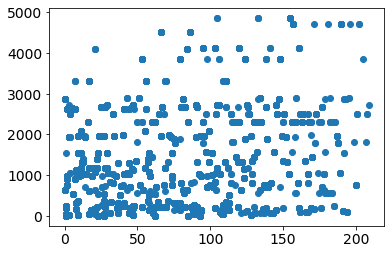

In [871]:
# Зависимость Healthcare_1 от DistrictId
plt.scatter(df_train[~df_train['Healthcare_1'].isna()]['DistrictId'], df_train[~df_train['Healthcare_1'].isna()]['Healthcare_1'])

In [872]:
# df_train['Healthcare_1'].value_counts().sort_index()
# df_train['Healthcare_1'].unique().tolist()

In [873]:
#plt.figure(figsize=(10,8), dpi= 80)
#sns.pairplot(df_train, kind="scatter", hue="species", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
#plt.show()

In [874]:
df_train['Square'].quantile(.975), df_train['Square'].quantile(.005)

(100.65086925347073, 28.090725390174164)

In [875]:
df_train['LifeSquare'].describe()

count    10000.000000
mean        33.845325
std         12.161227
min          8.822988
25%         24.465552
50%         32.076601
75%         40.827700
max        217.964981
Name: LifeSquare, dtype: float64

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

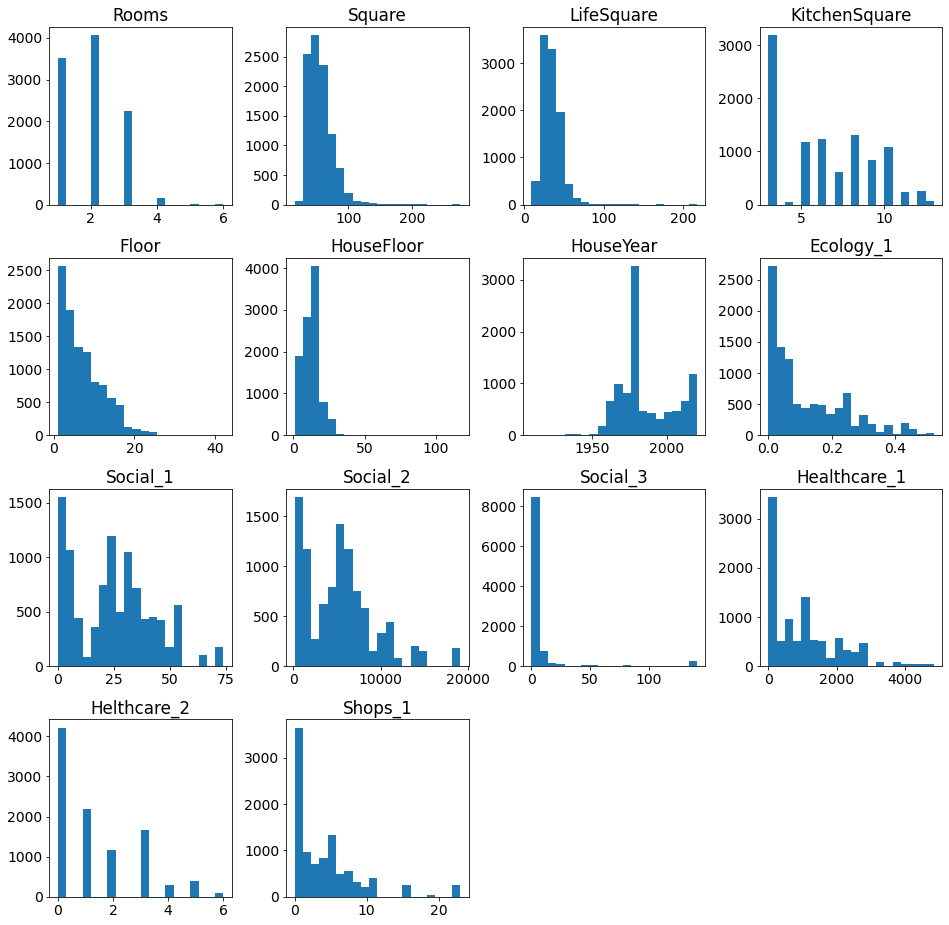

In [876]:
df_train[df_num_features_list].hist(figsize=(16, 16), bins=20, grid=False)

<AxesSubplot:>

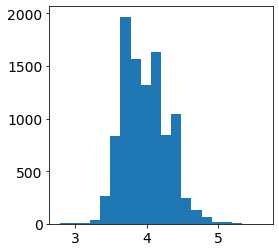

In [877]:
#pd.DataFrame[np.log(df_train['Square'])].hist(figsize=(4, 4), bins=20, grid=False)
np.log(df_train['Square']).hist(figsize=(4, 4), bins=20, grid=False)

In [878]:
list_for_corr = \
['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'PriceSQM',
 'median_room_square_by_DI_HY',
 'obj_num_by_DI_HY',
 'median_PriceSQM_by_DI_HY',
 'Square_restored',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'LifeSquare_restored',
 'LifeSquare_part',
 'Healthcare_1_pred']

In [879]:
corr_matrix = df_train[list_for_corr].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

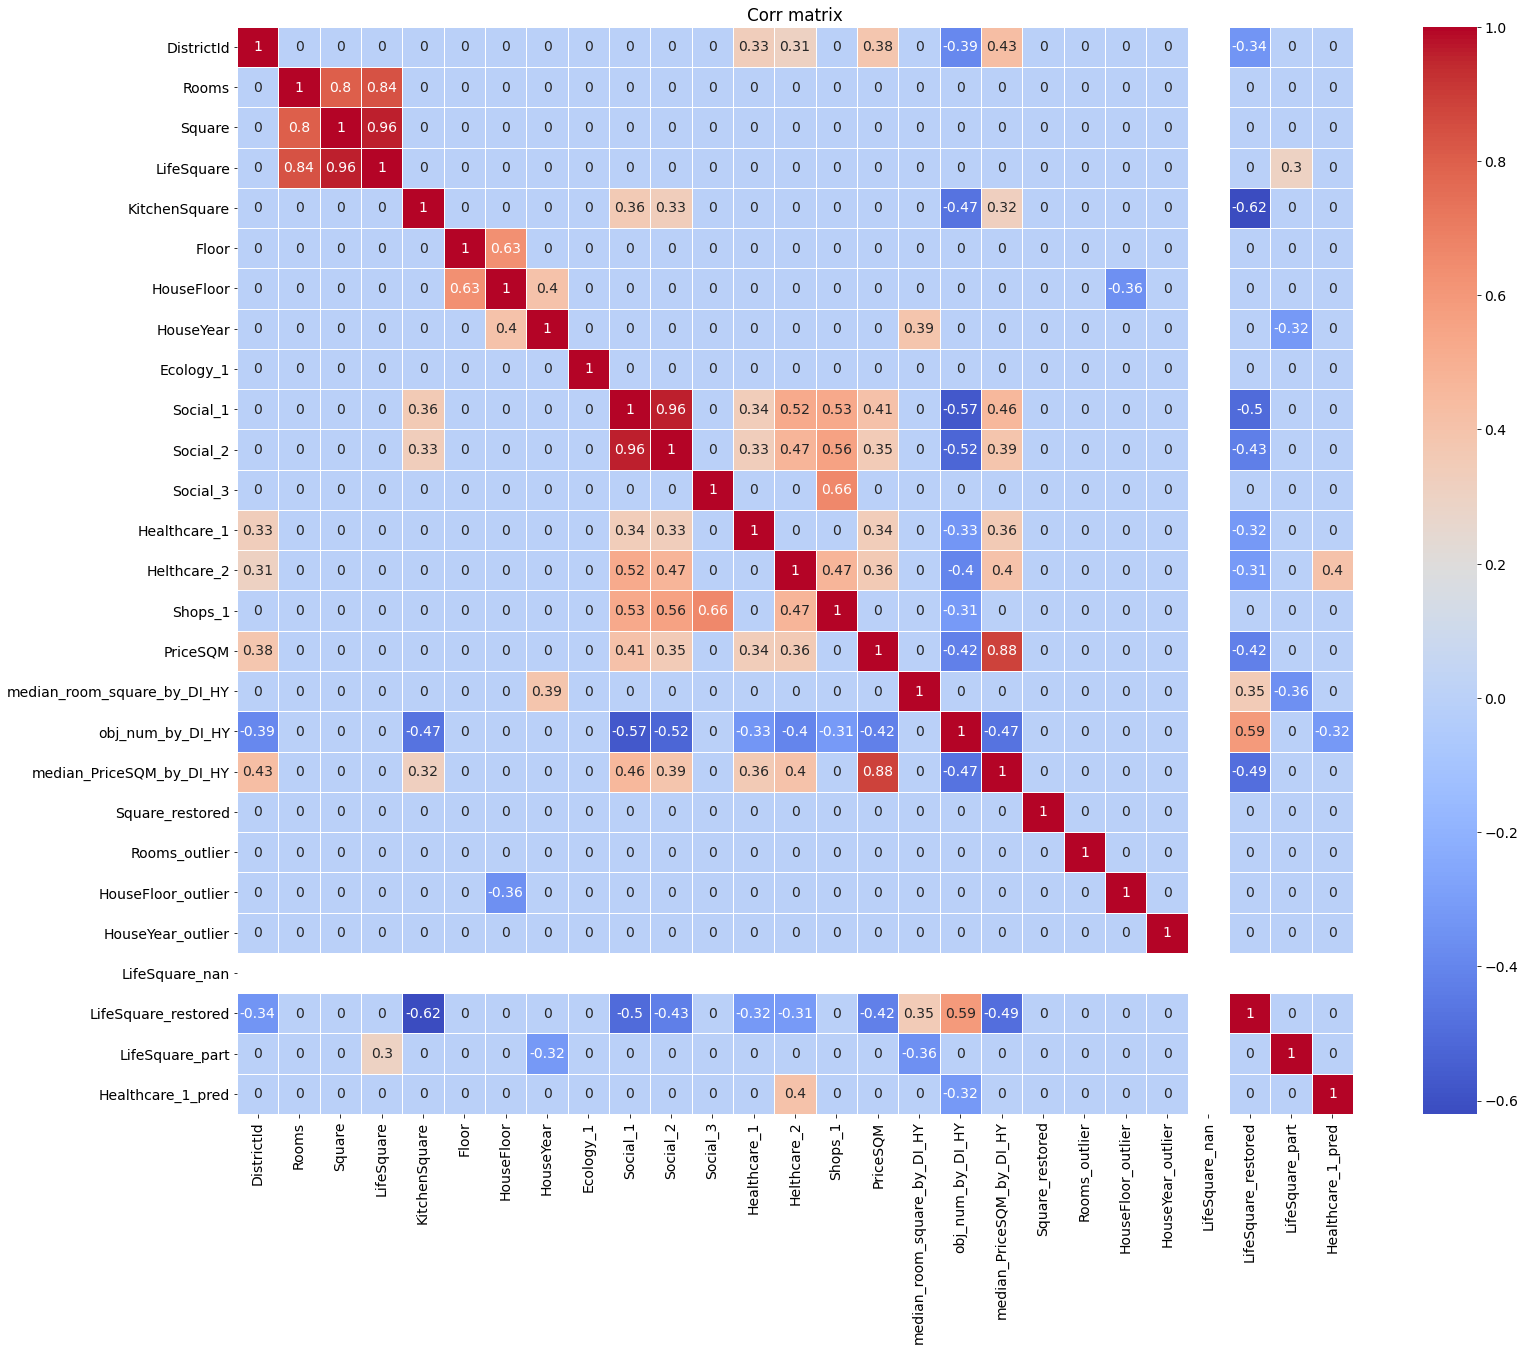

In [880]:
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('Corr matrix')
plt.show()

In [881]:
#grid = sns.jointplot(df_train['Square'], df_train['PriceSQM'])
#grid.fig.set_figwidth(5)
#grid.fig.set_figheight(5)
#plt.show()  # зависимость типа 1/Х

In [882]:
#plt.figure(figsize=(8, 4))
#sns.boxplot(df_train['Rooms'], df_train['PriceSQM'])
#plt.show() # нет зависимости.

In [883]:
#plt.figure(figsize=(15, 4))
#sns.boxplot(df_train['DistrictId'], df_train['PriceSQM'])
#plt.show() # нет зависимости.plt.show()  # зависимость типа 1/Х

In [884]:
#plt.figure(figsize=(15, 4))
#sns.boxplot(df_train['HouseYear'], df_train['PriceSQM'])
#plt.show() # нет зависимости.plt.show()  # зависимость типа 1/Х

In [885]:
#plt.figure(figsize=(8, 4))
#sns.boxplot(df_train['Social_3'], df_train['PriceSQM'])
#plt.show() # нет зависимости.

## Построение новых признаков

Разным районам соответствует разное количество объектов HC. Есть ли корреляция между количеством объектов MC на районе и стоимостью объекта.
Существуют ли районы для которых не указаны HC?
Является ли комбинация HC уникальной для района?
Проверить аналогичную комбинацию по 

In [886]:
df_train['Room_square'] = df_train['Square'] / df_train['Rooms']

In [887]:
# проведем эксперимент, прологарифмируем площадь
df_train['Square_log'] = np.log(df_train['Square'])

In [888]:
binary_to_numbers = {'A' : 0, 'B' : 1}
df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

In [889]:
## District
district_size = df_train['DistrictId'].value_counts().reset_index().\
            rename(columns = {'index':'DistrictId','DistrictId':'DistrictSize'})
district_size['DistrictId'] = district_size['DistrictId'].astype('str')
district_size.info()
#district_size

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DistrictId    205 non-null    object
 1   DistrictSize  205 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [890]:
district_size['DistrictId'] = district_size['DistrictId'].astype('int')
district_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   DistrictId    205 non-null    int32
 1   DistrictSize  205 non-null    int64
dtypes: int32(1), int64(1)
memory usage: 2.5 KB


In [891]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,LifeSquare_restored,LifeSquare_part,Healthcare_1_pred,Room_square,Square_log,DistrictSize
0,11809,27,3.0,115.027311,64.645864,10.0,4,10.0,2014,0.075424,...,0,0,0,0,1,0.56,0,38.342437,4.745170,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0.58,1,39.832524,3.684684,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0.61,1,26.114072,4.361087,652
3,2352,1,1.0,40.409907,24.885641,3.0,10,22.0,1977,0.007122,...,0,0,0,0,1,0.62,0,40.409907,3.699075,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,0.60,0,32.142534,4.163327,89


In [892]:
#plt.figure(figsize=(15, 4))
#sns.boxplot(df_train['DistrictSize'], df_train['PriceSQM'])
#plt.show() # нет зависимости.plt.show()  # зависимость типа 1/Х

In [893]:
(df_train['DistrictSize']> 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [894]:
df_train['DistrictLarge'] = (df_train['DistrictSize'] > 100) * 1
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,LifeSquare_restored,LifeSquare_part,Healthcare_1_pred,Room_square,Square_log,DistrictSize,DistrictLarge
0,11809,27,3.0,115.027311,64.645864,10.0,4,10.0,2014,0.075424,...,0,0,0,1,0.56,0,38.342437,4.745170,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0.58,1,39.832524,3.684684,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0.61,1,26.114072,4.361087,652,1
3,2352,1,1.0,40.409907,24.885641,3.0,10,22.0,1977,0.007122,...,0,0,0,1,0.62,0,40.409907,3.699075,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0.60,0,32.142534,4.163327,89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,0,0,0,0,0.68,0,24.545364,3.893670,118,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,1,0,0,0,0.58,0,32.153842,4.163679,851,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,0,0,0,0,0.56,0,29.648057,3.389397,7,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,0,0,0,0,0.69,1,32.330292,3.476005,165,1


In [895]:
# df_train_orig.info()
#df_train_sqm = df_train_orig[~df_train_orig['Healthcare_1'].isna()].copy()
#df_train_sqm['Price_sqm'] = (df_train_sqm['Price']/df_train_sqm['Square']).round(2)
#df_train_sqm
#df_train_sqm.sort_values(by='Healthcare_1').groupby(['DistrictId', 'Healthcare_1'] , as_index=False).agg({'Price_sqm':'describe'}).round(2)
#df_train_sqm.sort_values(by='Healthcare_1').groupby(['Healthcare_1'] , as_index=False).agg({'Price_sqm':'describe'}).round(2)
# посчитаем среднее значение целевого показателя в разраезе 'Healthcare_1'
#df_train_sqm.groupby(['Healthcare_1'] , as_index=False).agg({'Price_sqm':'describe'}).round(2)

In [896]:
median_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'PriceSQM':'median'})\
                     .rename(columns={'PriceSQM':'MedPriceSQM_ByDistrict'})
median_price_by_district.head()

,DistrictId,Rooms,MedPriceSQM_ByDistrict
0,0,1.0,4156.154900
1,0,2.0,3585.897779
2,0,3.0,4381.202499
3,1,1.0,3454.517822
4,1,2.0,3195.399523


In [897]:
median_price_by_district.shape

(670, 3)

In [898]:
if 'MedPriceSQM_ByDistrict' in df_train.columns:
    df_train.drop('MedPriceSQM_ByDistrict', axis=1,inplace=True)
df_train=df_train.merge(median_price_by_district, on=['DistrictId','Rooms'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,LifeSquare_restored,LifeSquare_part,Healthcare_1_pred,Room_square,Square_log,DistrictSize,DistrictLarge,MedPriceSQM_ByDistrict
0,11809,27,3.0,115.027311,64.645864,10.0,4,10.0,2014,0.075424,...,0,0,1,0.56,0,38.342437,4.745170,851,1,2772.530977
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0.58,1,39.832524,3.684684,78,0,3680.061716
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0.61,1,26.114072,4.361087,652,1,3000.364567
3,2352,1,1.0,40.409907,24.885641,3.0,10,22.0,1977,0.007122,...,0,0,1,0.62,0,40.409907,3.699075,652,1,3454.517822
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0.60,0,32.142534,4.163327,89,0,4288.696226


In [899]:
df_train['House_age'] = 2021 - df_train['HouseYear'] 

In [900]:
def House_age_to_cat_pandas(X):
    bins = [0, 5, 10, 20, 30, 40, 50, 70, 90, X['House_age'].max()]
    if 'House_age_cat' in X.columns:
        X.drop('House_age_cat', axis=1, inplace=True)
    X['House_age_cat'] = pd.cut(X['House_age'], bins=bins, labels=False)
    X['House_age_cat'].fillna(-1, inplace=True)
    return X

In [901]:
def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    if 'floor_cat' in X.columns:
        X.drop('floor_cat', axis=1, inplace=True)
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2010, X['HouseYear'].max()]
    if 'year_cat' in X.columns:
        X.drop('year_cat', axis=1, inplace=True)
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['year_cat'].fillna(-1, inplace=True)
    return X

def House_year_to_cat_pandas(X):
    bins = [0, 1930, 1950, 1960, 1970, 1980, 1995, 2010, X['HouseYear'].max()]
    if 'House_year_cat' in X.columns:
        X.drop('House_year_cat', axis=1, inplace=True)
    X['House_year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['House_year_cat'].fillna(-1, inplace=True)
    return X


In [902]:
df_train = floor_to_cat_pandas(df_train)
df_train = year_to_cat_pandas(df_train)
df_train = House_age_to_cat_pandas(df_train)
df_train = House_year_to_cat_pandas(df_train)

In [903]:
median_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'PriceSQM':'median'}).\
          rename(columns={'PriceSQM':'MedPriceSQM_ByFloorYear'})
median_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceSQM_ByFloorYear
0,0,0,5449.749154
1,0,1,5307.039966
2,0,2,5015.033668
3,0,3,2709.382466
4,1,0,4586.891058


In [904]:
if 'MedPriceSQM_ByFloorYear' in df_train.columns:
    df_train.drop('MedPriceSQM_ByFloorYear', axis=1, inplace=True)
df_train = df_train.merge(median_price_by_floor_year, on=['year_cat','floor_cat'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_log,DistrictSize,DistrictLarge,MedPriceSQM_ByDistrict,House_age,floor_cat,year_cat,House_age_cat,House_year_cat,MedPriceSQM_ByFloorYear
0,11809,27,3.0,115.027311,64.645864,10.0,4,10.0,2014,0.075424,...,4.745170,851,1,2772.530977,7,1,4,1,7,2873.233554
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,3.684684,78,0,3680.061716,55,2,2,6,3,4047.143487
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,4.361087,652,1,3000.364567,33,0,3,4,5,4229.987261
3,2352,1,1.0,40.409907,24.885641,3.0,10,22.0,1977,0.007122,...,3.699075,652,1,3454.517822,44,3,2,5,4,3211.752116
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,4.163327,89,0,4288.696226,49,4,2,5,4,3051.298133


In [905]:
#class FeatureGenerator():
# ['DistrictId', 'House_age']
median_price_by_HA = df_train.groupby(['House_age'], as_index=False).agg({'PriceSQM':'median'})\
                     .rename(columns={'PriceSQM':'MedPriceSQM_by_HA'})

if 'MedPriceSQM_by_HA' in df_train.columns:
    df_train.drop('MedPriceSQM_by_HA', axis=1, inplace=True)
df_train = df_train.merge(median_price_by_HA, on=['House_age'], how='left')
df_train.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictSize,DistrictLarge,MedPriceSQM_ByDistrict,House_age,floor_cat,year_cat,House_age_cat,House_year_cat,MedPriceSQM_ByFloorYear,MedPriceSQM_by_HA
0,11809,27,3.0,115.027311,64.645864,10.0,4,10.0,2014,0.075424,...,851,1,2772.530977,7,1,4,1,7,2873.233554,2804.496552
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,78,0,3680.061716,55,2,2,6,3,4047.143487,4376.488083
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,652,1,3000.364567,33,0,3,4,5,4229.987261,4447.681698
3,2352,1,1.0,40.409907,24.885641,3.0,10,22.0,1977,0.007122,...,652,1,3454.517822,44,3,2,5,4,3211.752116,2901.326376
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,89,0,4288.696226,49,4,2,5,4,3051.298133,4285.794408


## Отбор признаков

In [906]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           10000 non-null  object 
 1   DistrictId                   10000 non-null  int32  
 2   Rooms                        10000 non-null  float64
 3   Square                       10000 non-null  float64
 4   LifeSquare                   10000 non-null  float64
 5   KitchenSquare                10000 non-null  float64
 6   Floor                        10000 non-null  int64  
 7   HouseFloor                   10000 non-null  float64
 8   HouseYear                    10000 non-null  int64  
 9   Ecology_1                    10000 non-null  float64
 10  Ecology_2                    10000 non-null  int64  
 11  Ecology_3                    10000 non-null  int64  
 12  Social_1                     10000 non-null  int64  
 13  Social_2         

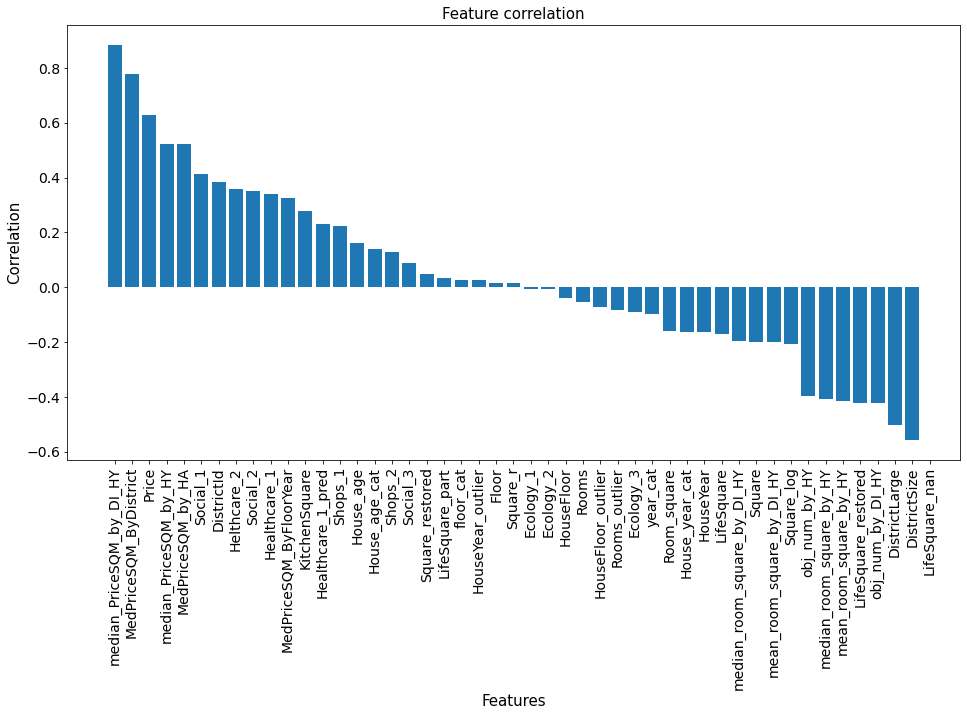

In [907]:
correlation = df_train.corrwith(df_train['PriceSQM']).sort_values(ascending=False)
correlation.drop('PriceSQM', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [908]:
df_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'PriceSQM',
       'mean_room_square_by_DI_HY', 'median_room_square_by_DI_HY',
       'obj_num_by_DI_HY', 'median_PriceSQM_by_DI_HY',
       'mean_room_square_by_HY', 'median_room_square_by_HY', 'obj_num_by_HY',
       'median_PriceSQM_by_HY', 'Square_restored', 'Square_r', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
       'LifeSquare_restored', 'LifeSquare_part', 'Healthcare_1_pred',
       'Room_square', 'Square_log', 'DistrictSize', 'DistrictLarge',
       'MedPriceSQM_ByDistrict', 'House_age', 'floor_cat', 'year_cat',
       'House_age_cat', 'House_year_cat', 'MedPriceSQM_ByFloorYear',
       'MedPriceSQM_by_HA'],
      dtype='object')

In [909]:
feature_names = [
#                 'DistrictId',
                 'Rooms',
#                 'Square',
                 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1',
                 'Ecology_2',
                 'Healthcare_1',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Helthcare_2',
                 'Shops_1', 'Shops_2']

target_name = 'Price'

In [910]:
new_feafure_names = [
        'median_room_square_by_DI_HY',
#        'obj_num_by_DI_HY',
        'median_PriceSQM_by_DI_HY',
#        'Square_restored',
#        'Rooms_outlier',
        'HouseFloor_outlier', 
#        'HouseYear_outlier',
#        'LifeSquare_nan',
        'LifeSquare_restored', 
        'LifeSquare_part',
        'Healthcare_1_pred',
#        'DistrictSize',
        'House_age', 'House_age_cat', 'floor_cat', 'year_cat',
        'MedPriceSQM_ByDistrict',
        'House_year_cat', 'MedPriceSQM_ByFloorYear',
        'MedPriceSQM_by_HA',
        'Square_log']

In [911]:
col_for_scale = ['LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                'Healthcare_1',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Helthcare_2',
                 'Shops_1'] + \
        ['median_room_square_by_DI_HY',
        'obj_num_by_DI_HY',
        'median_PriceSQM_by_DI_HY',
        'LifeSquare_part', 
        'DistrictSize',
        'House_age', 'House_age_cat', 'floor_cat',
#        'year_cat',
        'House_year_cat',
        'MedPriceSQM_ByFloorYear',
        'MedPriceSQM_by_HA',
        'Square_log']

In [912]:
df_train[feature_names + new_feafure_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rooms                        10000 non-null  float64
 1   LifeSquare                   10000 non-null  float64
 2   KitchenSquare                10000 non-null  float64
 3   Floor                        10000 non-null  int64  
 4   HouseFloor                   10000 non-null  float64
 5   HouseYear                    10000 non-null  int64  
 6   Ecology_1                    10000 non-null  float64
 7   Ecology_2                    10000 non-null  int64  
 8   Healthcare_1                 10000 non-null  float64
 9   Ecology_3                    10000 non-null  int64  
 10  Social_1                     10000 non-null  int64  
 11  Social_2                     10000 non-null  int64  
 12  Social_3                     10000 non-null  int64  
 13  Helthcare_2      

## Разбиение на train и nest

In [913]:
import warnings
warnings.filterwarnings('ignore')

In [914]:
#df_train = pd.read_csv(DS_TRAIN_ORIG_PATH, sep=',')
#df_test = pd.read_csv(DS_TEST_ORIG_PATH, sep=',')


In [915]:
y = df_train[target_name]
X = df_train #.drop(columns=target_name)

In [916]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [917]:
#prepr = DataPreprocessing()

In [918]:
#prepr.fit(X_train)

In [919]:
#X_train = prepr.transform(X_train)

In [920]:
#X_valid = prepr.transform(X_valid)

In [921]:
y_train_sqm = y_train.values / X_train['Square']
y_valid_sqm = y_valid.values / X_valid['Square']
#y_train_sqm = np.clip(y_train_sqm, a_min=800, a_max=8000)
#y_valid_sqm = np.clip(y_valid_sqm, a_min=800, a_max=8000)

In [922]:
type(X_train)

pandas.core.frame.DataFrame

In [923]:
print(type(y_train))
print(type(y_train.values))
print(type(y_train_sqm))
print(type(X_train['Square']))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [924]:
y_train.count(), X_train['Square'].count(), y_train_sqm.count()

(6700, 6700, 6700)

In [925]:
X_train['PriceSQM'] = y_train_sqm.values

In [926]:
X_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,DistrictSize,DistrictLarge,MedPriceSQM_ByDistrict,House_age,floor_cat,year_cat,House_age_cat,House_year_cat,MedPriceSQM_ByFloorYear,MedPriceSQM_by_HA
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,50.159701,1.915672,56.144521,33.818595,6.246716,7.396418,12.942388,1984.821791,0.119933,0.990746,...,243.381045,0.506567,3914.319049,36.178209,1.666567,2.554627,3.978955,4.613433,3827.979919,3783.724938
std,43.501559,0.804465,18.894688,12.159142,2.795171,5.082498,6.324812,18.297810,0.119618,0.095757,...,270.338797,0.499994,1047.195556,18.297810,1.286135,0.780319,1.927714,1.441437,541.490650,761.183825
min,0.000000,1.000000,16.547242,9.299624,3.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,...,1.000000,0.000000,810.825491,1.000000,0.000000,0.000000,0.000000,0.000000,2709.382466,2804.496552
25%,20.000000,1.000000,41.967402,24.523184,3.000000,3.000000,9.000000,1974.000000,0.017647,1.000000,...,55.000000,0.000000,3000.364567,20.000000,0.000000,2.000000,2.000000,4.000000,3211.752116,2901.326376
50%,35.000000,2.000000,52.652900,32.129739,6.000000,6.000000,13.000000,1977.000000,0.075779,1.000000,...,104.000000,1.000000,4065.045010,44.000000,2.000000,2.000000,5.000000,4.000000,4047.143487,4285.794408
75%,75.000000,2.000000,65.772266,40.636172,8.000000,11.000000,17.000000,2001.000000,0.195781,1.000000,...,511.000000,1.000000,4596.878709,47.000000,3.000000,3.000000,5.000000,6.000000,4229.987261,4409.376396
max,209.000000,6.000000,275.645284,217.964981,13.000000,42.000000,99.000000,2020.000000,0.521867,1.000000,...,851.000000,1.000000,11854.652892,109.000000,4.000000,4.000000,8.000000,7.000000,6766.013241,7823.822055


In [927]:
#X_train.sort_values(by='PriceSQM', ascending=False)[[ 'Rooms', 'Square', 'HouseYear', 'PriceSQM', 'Price']].head(30)

In [928]:
#df_test = prepr.transform(df_test)

In [929]:
#Убедимся, что все прошло благополучно, полученные датасеты имеют одинаковый размер
# в оригинальной задаче 22 признака у меня 21?
X_train.shape, X_valid.shape #, df_test.shape

((6700, 50), (3300, 50))

In [930]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 9239 to 5327
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           6700 non-null   object 
 1   DistrictId                   6700 non-null   int32  
 2   Rooms                        6700 non-null   float64
 3   Square                       6700 non-null   float64
 4   LifeSquare                   6700 non-null   float64
 5   KitchenSquare                6700 non-null   float64
 6   Floor                        6700 non-null   int64  
 7   HouseFloor                   6700 non-null   float64
 8   HouseYear                    6700 non-null   int64  
 9   Ecology_1                    6700 non-null   float64
 10  Ecology_2                    6700 non-null   int64  
 11  Ecology_3                    6700 non-null   int64  
 12  Social_1                     6700 non-null   int64  
 13  Social_2       

In [931]:
#Проверим в какое значение установились свойства класса после обучения
#prepr.kitchen_square_quantile

In [932]:
y_train_sqm

9239    3159.410326
6930    2373.230546
8136    2476.799680
3424    3281.365132
6518    2337.773090
           ...     
9336    4132.423182
48      4013.749937
8964    4361.722365
5944    3119.087491
5327    3902.843205
Name: Square, Length: 6700, dtype: float64

In [933]:
#features_gen = FeatureGenerator()
#features_gen.fit(X_train, y_train)

In [934]:
#features_gen.median_price_by_district

In [935]:
#X_train = features_gen.transform(X_train)
#X_valid = features_gen.transform(X_valid)
#df_test = features_gen.transform(df_test)

In [936]:
# в оригинальной задаче 29 призаков, у меня 27?
X_train.shape, X_valid.shape, df_test.shape

((6700, 50), (3300, 50), (5000, 19))

In [937]:

from sklearn.feature_extraction import FeatureHasher
df_district = pd.DataFrame(df_train['DistrictId'].unique(),columns=['DistrictId']).copy()
#df_district['DistrictId'] = df_district['DistrictId'].astype('str')
hashing=FeatureHasher(input_type='string', n_features=10)
df_district_hash = pd.DataFrame(hashing.transform(df_district['DistrictId'].astype('str')).toarray())
for c in df_district_hash.columns:
    df_district_hash.rename(columns={c:'DistrId_'+str(c)}, inplace=True)
df_district_hash = pd.concat([df_district, df_district_hash], axis=1)
feature_distr = ['DistrId_0', 'DistrId_1', 'DistrId_2', 'DistrId_3', 'DistrId_4', 'DistrId_5', 'DistrId_6', 
                 'DistrId_7', 'DistrId_8', 'DistrId_9']
#X_train_dsh = X_train.merge(df_district_hash, on='DistrictId', how='left')


In [938]:
#df_district_hash.sort_values(by='DistrictId').head(60)
df_district_hash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DistrictId  205 non-null    int32  
 1   DistrId_0   205 non-null    float64
 2   DistrId_1   205 non-null    float64
 3   DistrId_2   205 non-null    float64
 4   DistrId_3   205 non-null    float64
 5   DistrId_4   205 non-null    float64
 6   DistrId_5   205 non-null    float64
 7   DistrId_6   205 non-null    float64
 8   DistrId_7   205 non-null    float64
 9   DistrId_8   205 non-null    float64
 10  DistrId_9   205 non-null    float64
dtypes: float64(10), int32(1)
memory usage: 16.9 KB


In [939]:
#scaler_X = RobustScaler()

In [940]:
#X_train[col_for_scale] = scaler_X.fit_transform(X_train[col_for_scale])

In [941]:
#X_valid[col_for_scale] = scaler_X.transform(X_valid[col_for_scale])

In [942]:
if 'DistrId_0' in X_train:
    X_train_h.drop(feature_distr, axis=1, inplace=True)
X_train = X_train.merge(df_district_hash, on='DistrictId', how='left')

In [943]:
if 'DistrId_0' in X_valid:
    X_valid_h.drop(feature_distr, axis=1, inplace=True)
X_valid = X_valid.merge(df_district_hash, on='DistrictId', how='left')

In [944]:
#if 'DistrId_0' in df_test:
#    df_test.drop(feature_distr, axis=1, inplace=True)
#df_test = df_test.merge(df_district_hash, on='DistrictId', how='left')

In [945]:
# проверим сколько уникальных значений в массиве 
#features_gen.median_price_by_district['MedPriceSQM_ByDistrict'].nunique()

In [946]:
#X_train = X_train[feature_names + new_feafure_names + feature_distr]
X_train_square = X_train['Square']
X_train = X_train[feature_names + new_feafure_names]

In [947]:
#X_valid = X_valid[feature_names + new_feafure_names + feature_distr]
X_valid_square = X_valid['Square']
X_valid = X_valid[feature_names + new_feafure_names]

In [948]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()#, df_test.isna().sum().sum()

(0, 0)

## Построение модели

In [949]:
rf_model = RandomForestRegressor(max_depth=6, min_samples_leaf=5 ,random_state=21, criterion='mse')
rf_model.fit(X_train, y_train_sqm)

RandomForestRegressor(max_depth=6, min_samples_leaf=5, random_state=21)

Оценка модели

In [950]:
y_train_sqm_preds = rf_model.predict(X_train)

In [951]:
y_valid_sqm_preds = rf_model.predict(X_valid)

In [952]:
pd.concat([pd.concat([pd.concat([X_train, pd.DataFrame(y_train_sqm.values, columns=['PriceSQM'])], axis=1), pd.DataFrame(y_train_sqm_preds, columns=['PriceSQM_preds']) ], axis=1), pd.DataFrame(y_train.values, columns=['Price'])], axis=1).to_csv(DS_TRAIN_PREP_PATH, index=False)


In [953]:
y_train_preds = y_train_sqm_preds * X_train_square
y_valid_preds = y_valid_sqm_preds * X_valid_square

In [954]:
y_train_sqm.shape, y_train.shape, y_train_sqm_preds.shape, y_train_sqm.shape, X_train_square.shape

((6700,), (6700,), (6700,), (6700,), (6700,))

In [955]:
y_train_preds

0       113961.165675
1       216585.547222
2       220956.402621
3       201541.601302
4       147413.588285
            ...      
6695    319848.763789
6696    225533.318786
6697    205645.934434
6698    136020.728487
6699    252715.398793
Name: Square, Length: 6700, dtype: float64

In [956]:
#pd.DataFrame({'Price':y_train.values, 'Price_pred':y_train_preds.values})

In [957]:
type(y_train_sqm_preds)

numpy.ndarray

In [958]:
r2((y_train_sqm.values * X_train_square) ,( y_train_sqm_preds* X_train_square))

0.8899390598327851

Train R2:	0.89
Test R2:	0.867


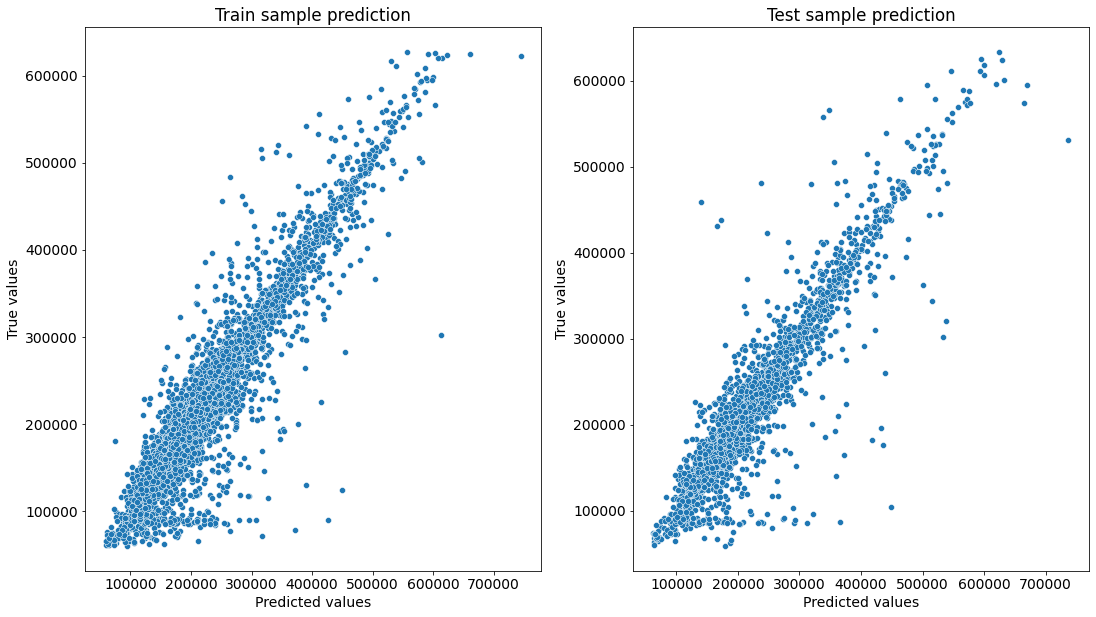

In [959]:
evaluate_preds(y_train.values, y_train_preds, y_valid.values, y_valid_preds)

In [960]:
cv_score = cross_val_score(rf_model, X_train, y_train_sqm, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.80470973, 0.78272733, 0.80642462])

In [961]:
cv_score.mean()

0.797953889575365

### важность признаков

In [962]:
feature_importances = pd.DataFrame(zip(X_train.columns,rf_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,median_PriceSQM_by_DI_HY,0.953030
30,Square_log,0.012045
26,MedPriceSQM_ByDistrict,0.009047
1,LifeSquare,0.007569
11,Social_2,0.002078
8,Healthcare_1,0.001818
4,HouseFloor,0.001803
20,LifeSquare_part,0.001784
6,Ecology_1,0.001758
16,median_room_square_by_DI_HY,0.001463


In [988]:
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
#from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor

In [964]:
#lrr = Ridge(alpha=0.01, random_state=21)

In [965]:
#lrr.fit(X_train, y_train_sqm)

In [966]:
#y_train_sqm_preds = lrr.predict(X_train)

In [967]:
#y_test_sqm_preds = lrr.predict(X_valid)

In [968]:
#from sklearn.ensemble import BaggingRegressor

In [969]:
#br_model = BaggingRegressor(base_estimator=rf_model, n_estimators=10, n_jobs=-1, random_state=21)

In [970]:
#br_model.fit(X_train, y_train_sqm)

In [971]:
#br_model.fit(X_train, y_train_sqm)

In [972]:
#y_train_sqm_preds = br_model.predict(X_train)

In [973]:
#!pip install catboost
from catboost import CatBoostRegressor, Pool, cv, sum_models

In [975]:
features_list = X_train.columns.to_list()
cat_features_names = [\
 'DistrictId',   
 'Rooms',
 'Floor',
 'HouseFloor',
 'Healthcare_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'HouseFloor_outlier',
 'LifeSquare_restored',
 'Healthcare_1_pred',
 'House_age',
 'House_age_cat',
 'floor_cat',
 'year_cat',
 'House_year_cat']

cat_features_index = []
for i in features_list:
    if i in cat_features_names:
        cat_features_index.append(features_list.index(i))


In [976]:
X_train.iloc[:,cat_features_index]#.select_dtypes(include=['float64', 'float32', 'float16'])

,Rooms,Floor,HouseFloor,Ecology_2,Healthcare_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,HouseFloor_outlier,LifeSquare_restored,Healthcare_1_pred,House_age,House_age_cat,floor_cat,year_cat,House_year_cat
0,1.0,18,25.0,1,1547.0,1,6,1437,3,0,2,1,0,1,0,44,5,4,2,4
1,3.0,3,16.0,1,1046.0,1,22,6398,141,3,23,1,0,1,1,44,5,0,2,4
2,2.0,7,12.0,1,192.0,1,16,4048,3,1,3,1,1,0,0,42,5,2,2,4
3,2.0,3,9.0,1,1937.0,1,37,5288,0,3,2,1,0,0,1,47,5,0,2,4
4,1.0,4,13.0,1,0.0,1,2,629,1,0,0,0,1,1,0,44,5,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,3.0,2,5.0,1,645.0,1,30,5285,0,6,6,1,1,0,1,61,6,0,2,2
6696,1.0,13,14.0,1,2301.0,1,35,7077,56,3,19,1,0,1,1,47,5,3,2,4
6697,2.0,2,5.0,1,750.0,1,33,7425,1,2,5,1,0,1,0,54,6,0,2,3
6698,1.0,5,12.0,0,370.0,1,9,1768,0,0,0,0,0,0,1,37,4,1,3,5


In [977]:
for  i  in X_train.iloc[:,cat_features_index].select_dtypes(include=['float64', 'float32', 'float16']):
    X_train[i] = X_train[i].astype('int') 

In [978]:
for  i  in X_valid.iloc[:,cat_features_index].select_dtypes(include=['float64', 'float32', 'float16']):
    X_valid[i] = X_valid[i].astype('int') 

In [979]:
X_train.iloc[:,cat_features_index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 6699
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Rooms                6700 non-null   int32
 1   Floor                6700 non-null   int64
 2   HouseFloor           6700 non-null   int32
 3   Ecology_2            6700 non-null   int64
 4   Healthcare_1         6700 non-null   int32
 5   Ecology_3            6700 non-null   int64
 6   Social_1             6700 non-null   int64
 7   Social_2             6700 non-null   int64
 8   Social_3             6700 non-null   int64
 9   Helthcare_2          6700 non-null   int64
 10  Shops_1              6700 non-null   int64
 11  Shops_2              6700 non-null   int64
 12  HouseFloor_outlier   6700 non-null   int64
 13  LifeSquare_restored  6700 non-null   int64
 14  Healthcare_1_pred    6700 non-null   int64
 15  House_age            6700 non-null   int64
 16  House_age_cat        670

In [980]:
train_dataset = Pool(data=X_train,
                     label=y_train_sqm,
                     cat_features=cat_features_index)
train_dataset

In [981]:
eval_dataset = Pool(data=X_valid,
                    label=y_valid_sqm,
                    cat_features=cat_features_index)

In [982]:
#train_dataset = Pool(data=X_train,
#                     label=y_train,
#                     cat_features=cat_features_index)


catb_model = CatBoostRegressor(iterations=1000,
                           grow_policy="Depthwise",
                           loss_function = 'RMSE',
                           min_data_in_leaf = 15,
                           eval_metric = 'R2',
                           early_stopping_rounds = 100,
                           # task_type="GPU", # закомментировать, если не на GPU
                           # devices='0', # закомментировать, если не на GPU
                           verbose = False,
                           use_best_model=True,
#                           max_depth = 7,
                           random_state = 21
                         )




In [983]:
catb_model.fit(train_dataset, eval_set=eval_dataset, logging_level='Silent', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [984]:
Y_hat_train = [yhat for yhat in catb_model.predict(X_train)]
Y_hat = [yhat for yhat in catb_model.predict(X_valid)]

from sklearn.metrics import r2_score
print(r2_score(y_train, Y_hat_train))
print(r2_score(y_valid, Y_hat))

-5.138653467566179
-5.05948582052994


In [985]:
#y_valid_sqm_preds = catb_model.predict(X_valid)

Train R2:	0.848
Test R2:	0.797


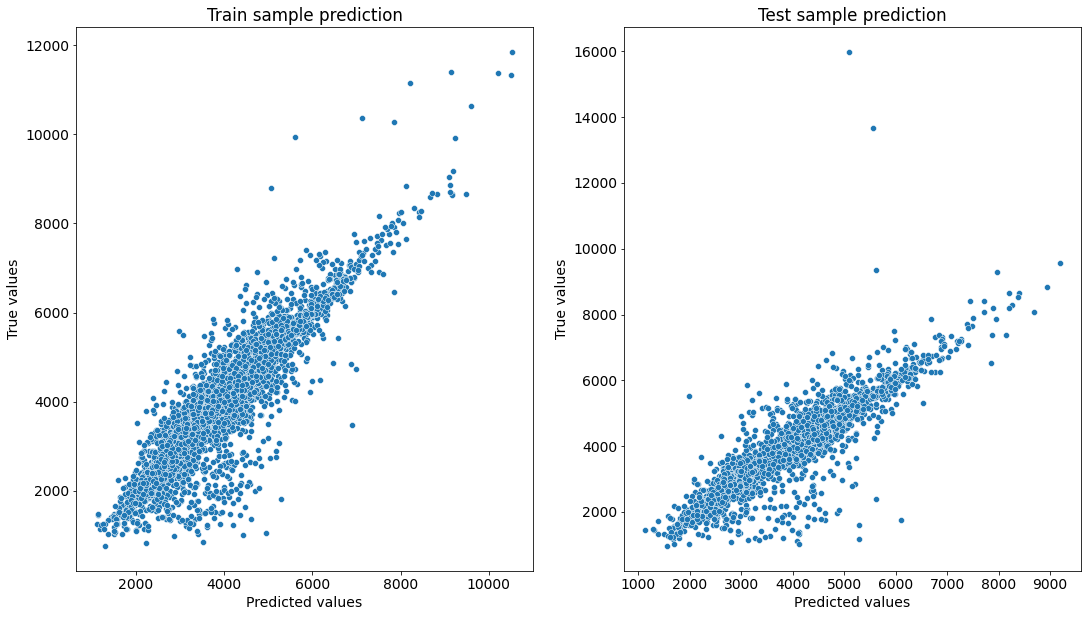

In [986]:
evaluate_preds(y_train_sqm, Y_hat_train, y_valid_sqm, Y_hat)

In [989]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor

#lr = LinearRegression(random_state=21)
lr = Ridge(random_state=21)
gb = GradientBoostingRegressor(random_state=21, )
br = BaggingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)

In [990]:
stack.fit(X_train, y_train_sqm)

StackingRegressor(estimators=[('lr', Ridge(random_state=21)),
                              ('rf',
                               RandomForestRegressor(max_depth=6,
                                                     min_samples_leaf=5,
                                                     random_state=21))],
                  final_estimator=GradientBoostingRegressor(random_state=21))

In [991]:
y_train_sqm_preds = stack.predict(X_train)

In [992]:
y_test_sqm_preds = stack.predict(X_valid)

Train R2:	0.821
Test R2:	0.788


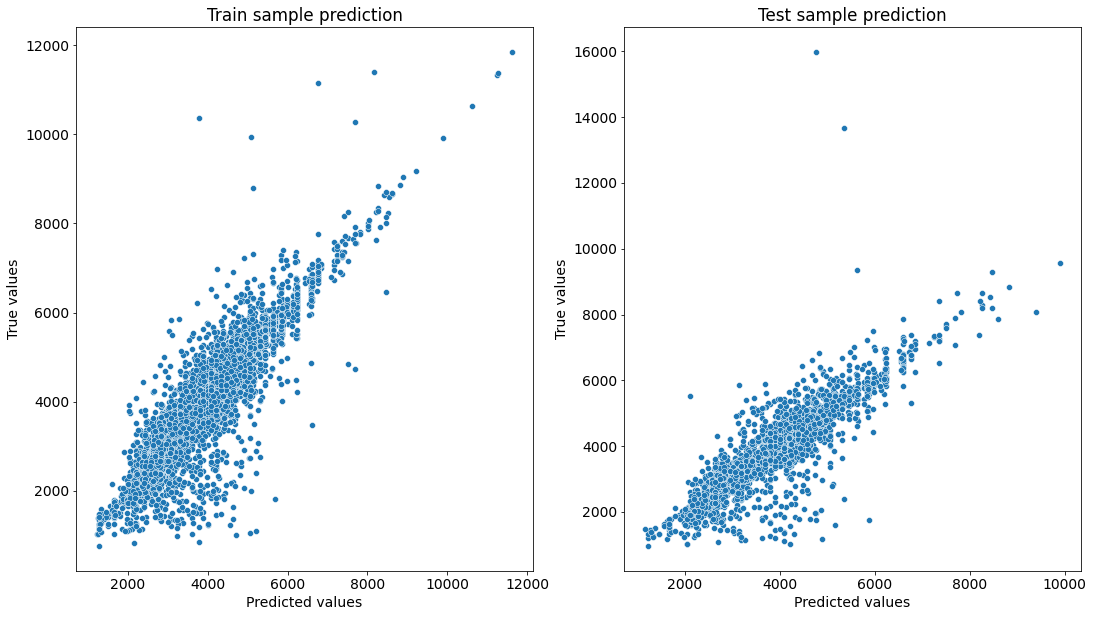

In [993]:
evaluate_preds(y_train_sqm, y_train_sqm_preds, y_valid_sqm, y_test_sqm_preds)

## Прогнозирование на тестовом датасете

In [994]:
# Преобразование тестовых данных не произвоидось прогнозирование не тестовых данных в этом ноутбуке невозможно.
#df_test.shape

In [ ]:
#df_test

In [ ]:
#prediction = rf_model.predict(df_test)

In [ ]:
#prediction

In [ ]:
#submit = pd.read_csv(DS_SUBMIT_SAMPLE_PATH)

In [ ]:
#submit['Price'] = prediction
#submit.head()

In [ ]:
#submit.to_csv(DS_SUBMIT_PATH, index=False)

In [ ]:
#plt.scatter(X_train['DistrictSize'], y_train_sqm.values)

In [ ]:
#plt.scatter(X_train['DistrictLarge'], y_train_sqm.values)